In [1]:
import numpy as np # linear algebra
import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
import cv2
import zipfile
import os
from PIL import Image
import os
import re
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from collections import Counter

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [5]:
!kaggle competitions download -c dl-2025-competition-1

In [6]:
file_path = '/content/dl-2025-competition-1.zip'

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

In [7]:
train_transform = A.Compose([
    A.Resize(224,224,  interpolation = cv2.INTER_CUBIC),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=30, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),

    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.7),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.CLAHE(p=0.3),
    A.RandomBrightnessContrast(p=0.5),

    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),

    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
   A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

ToTensorV2()]
)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-7-00efe454dc54>:7: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
<ipython-input-7-00efe454dc54>:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
<ipython-input-7-00efe454dc54>:17: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),


In [8]:
class SortedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform

        self.class_folders = sorted(
            [d for d in os.listdir(root_dir) if d.isdigit()],
            key=lambda x: int(x)
        )

        self.samples = []
        self.targets = []
        for class_idx, folder_name in enumerate(self.class_folders):
            folder_path = os.path.join(root_dir, folder_name)
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder_path, img_name)
                    self.samples.append((img_path, class_idx))
                    self.targets.append(class_idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

    @property
    def num_classes(self):
        return len(self.class_folders)

In [9]:
data =  '/content/drive/MyDrive/kaggle/data/train'
dataset = SortedImageDataset(data,transform=train_transform)

Рассмотрим вариации аугментаций на одних и тех же картинках

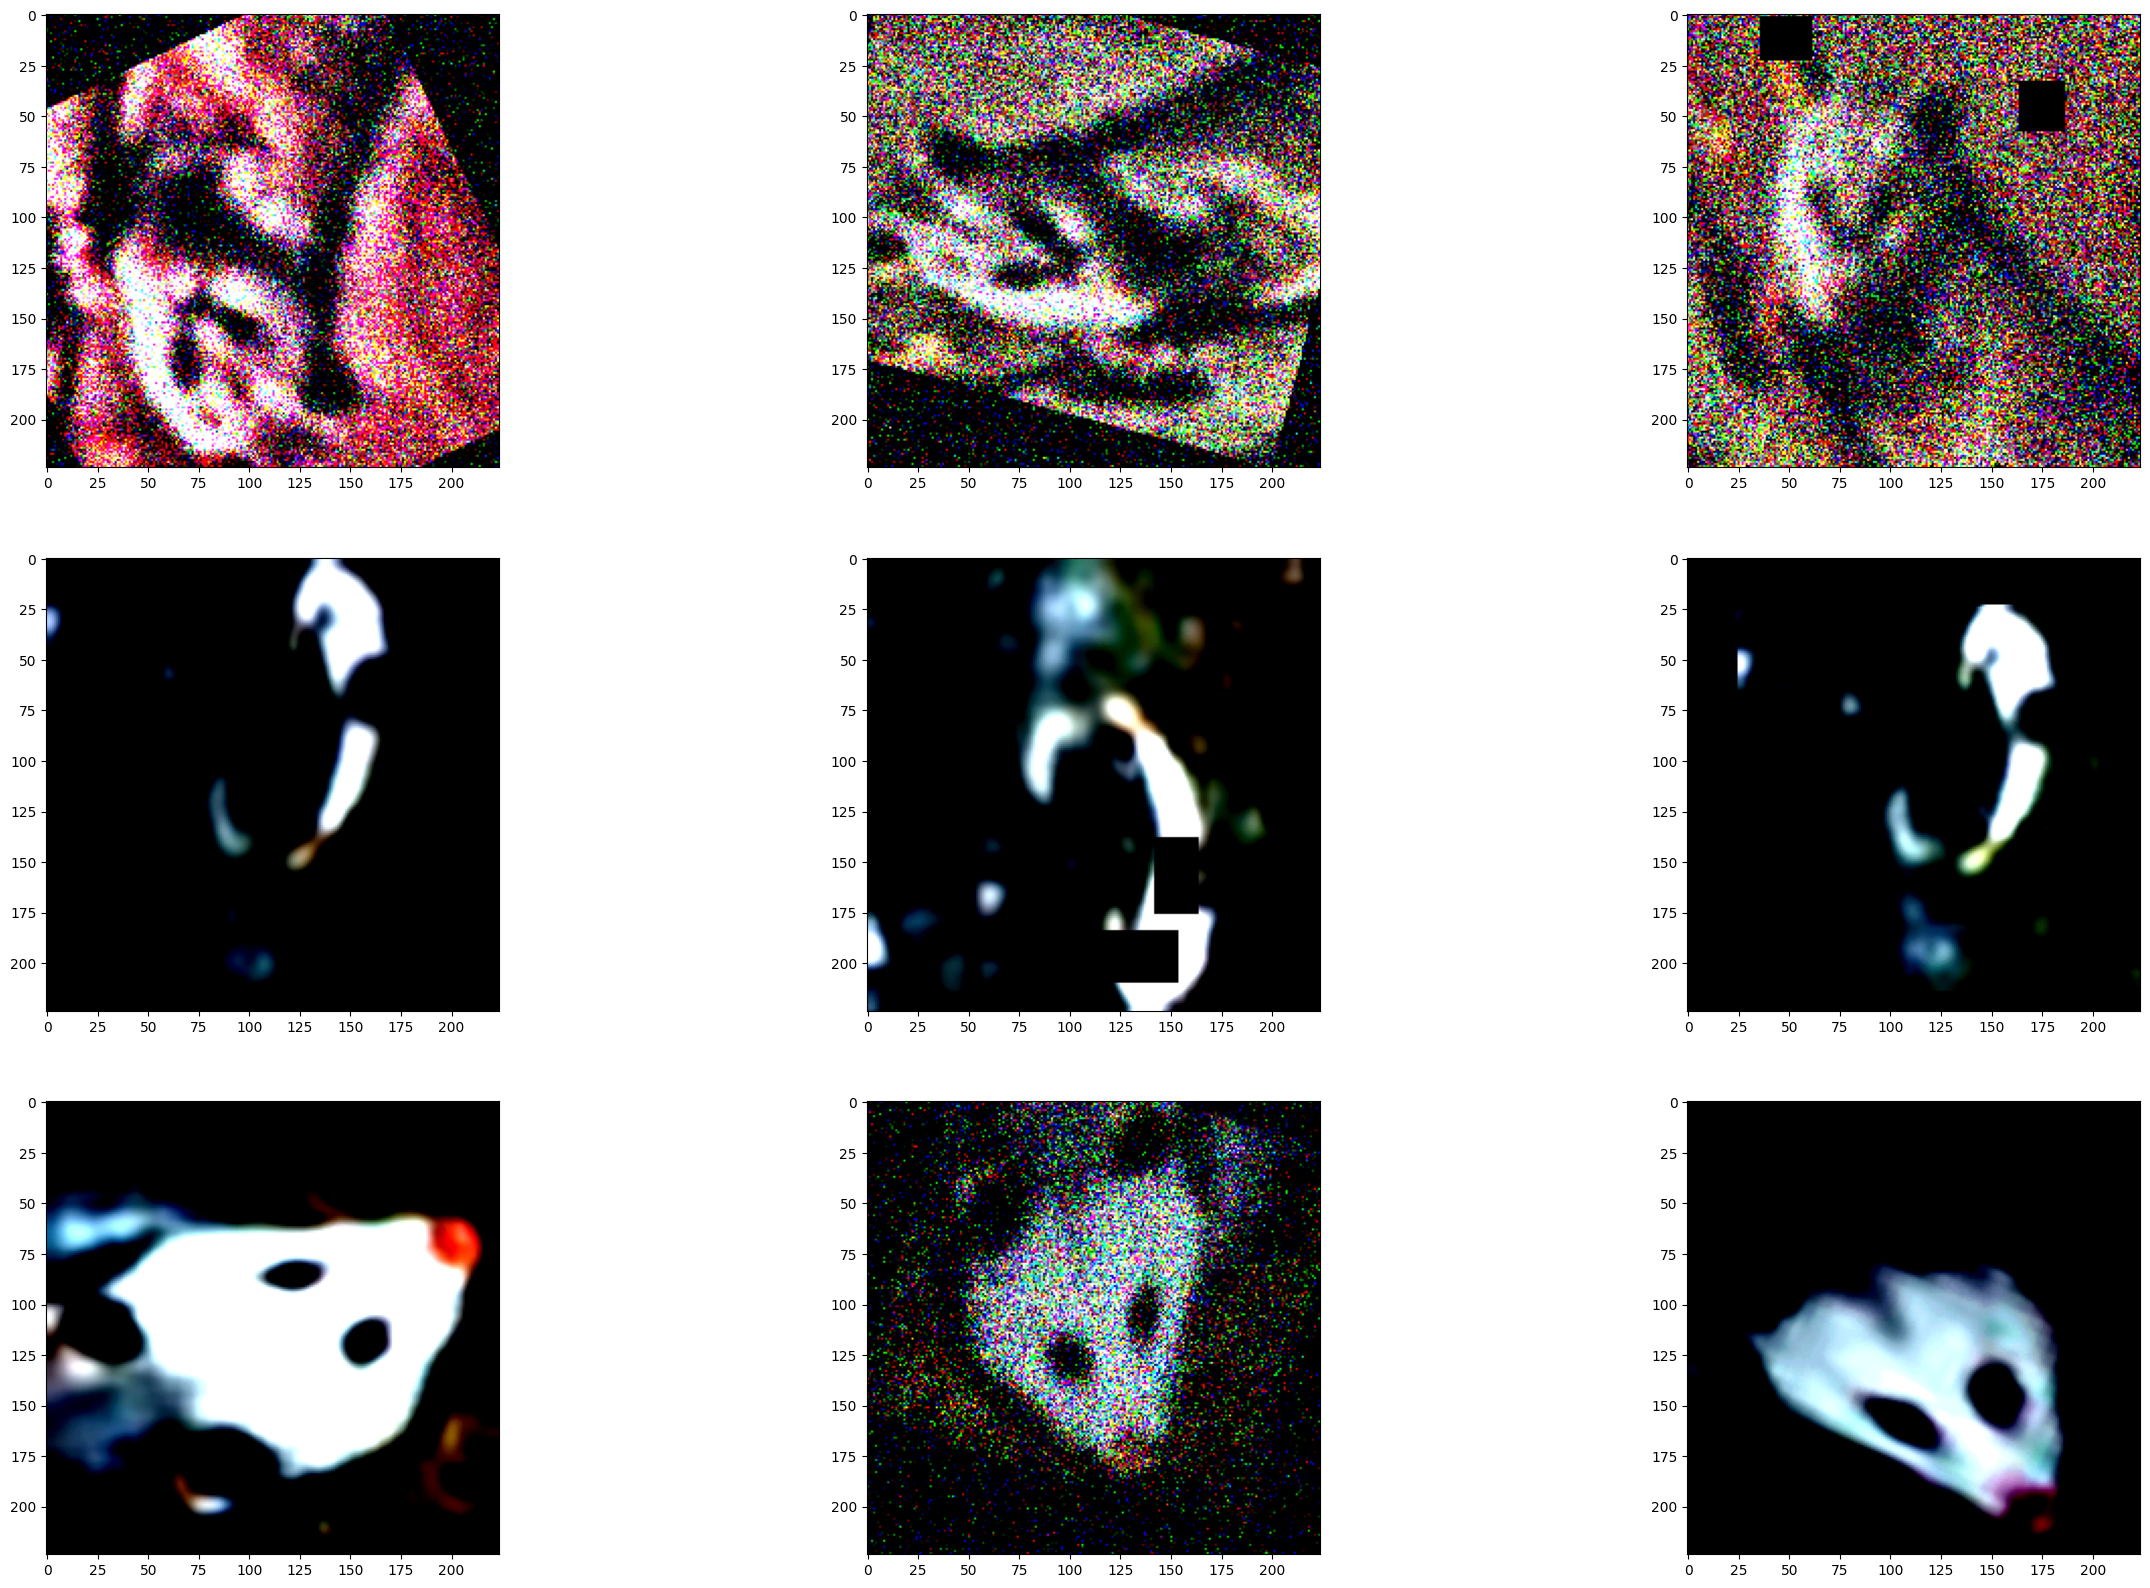

In [10]:
fig,axes = plt.subplots(3,3, figsize=(30,20))
for i in range(3):
  for j in range(3):
    axes[i][j].imshow(dataset[i][0].permute(1,2,0))

Посмотрим на распредление классов , и вычленим классы в которых не хватает данных для дальнейшей генерации



Статистика по классам:
Всего классов: 100
Всего изображений: 9510

Количество изображений по классам:
0: 110 (1.2%)
1: 109 (1.1%)
2: 143 (1.5%)
3: 119 (1.3%)
4: 136 (1.4%)
5: 45 (0.5%)
6: 123 (1.3%)
7: 137 (1.4%)
8: 45 (0.5%)
9: 49 (0.5%)
10: 134 (1.4%)
11: 72 (0.8%)
12: 117 (1.2%)
13: 109 (1.1%)
14: 50 (0.5%)
15: 137 (1.4%)
16: 125 (1.3%)
17: 140 (1.5%)
18: 47 (0.5%)
19: 87 (0.9%)
20: 138 (1.5%)
21: 131 (1.4%)
22: 115 (1.2%)
23: 32 (0.3%)
24: 117 (1.2%)
25: 70 (0.7%)
26: 44 (0.5%)
27: 128 (1.3%)
28: 149 (1.6%)
29: 118 (1.2%)
30: 128 (1.3%)
31: 78 (0.8%)
32: 88 (0.9%)
33: 46 (0.5%)
34: 118 (1.2%)
35: 72 (0.8%)
36: 118 (1.2%)
37: 58 (0.6%)
38: 125 (1.3%)
39: 104 (1.1%)
40: 125 (1.3%)
41: 149 (1.6%)
42: 108 (1.1%)
43: 34 (0.4%)
44: 135 (1.4%)
45: 133 (1.4%)
46: 95 (1.0%)
47: 61 (0.6%)
48: 70 (0.7%)
49: 108 (1.1%)
50: 55 (0.6%)
51: 139 (1.5%)
52: 127 (1.3%)
53: 56 (0.6%)
54: 117 (1.2%)
55: 76 (0.8%)
56: 139 (1.5%)
57: 127 (1.3%)
58: 80 (0.8%)
59: 146 (1.5%)
60: 37 (0.4%)
61: 80 (0.8%)
62

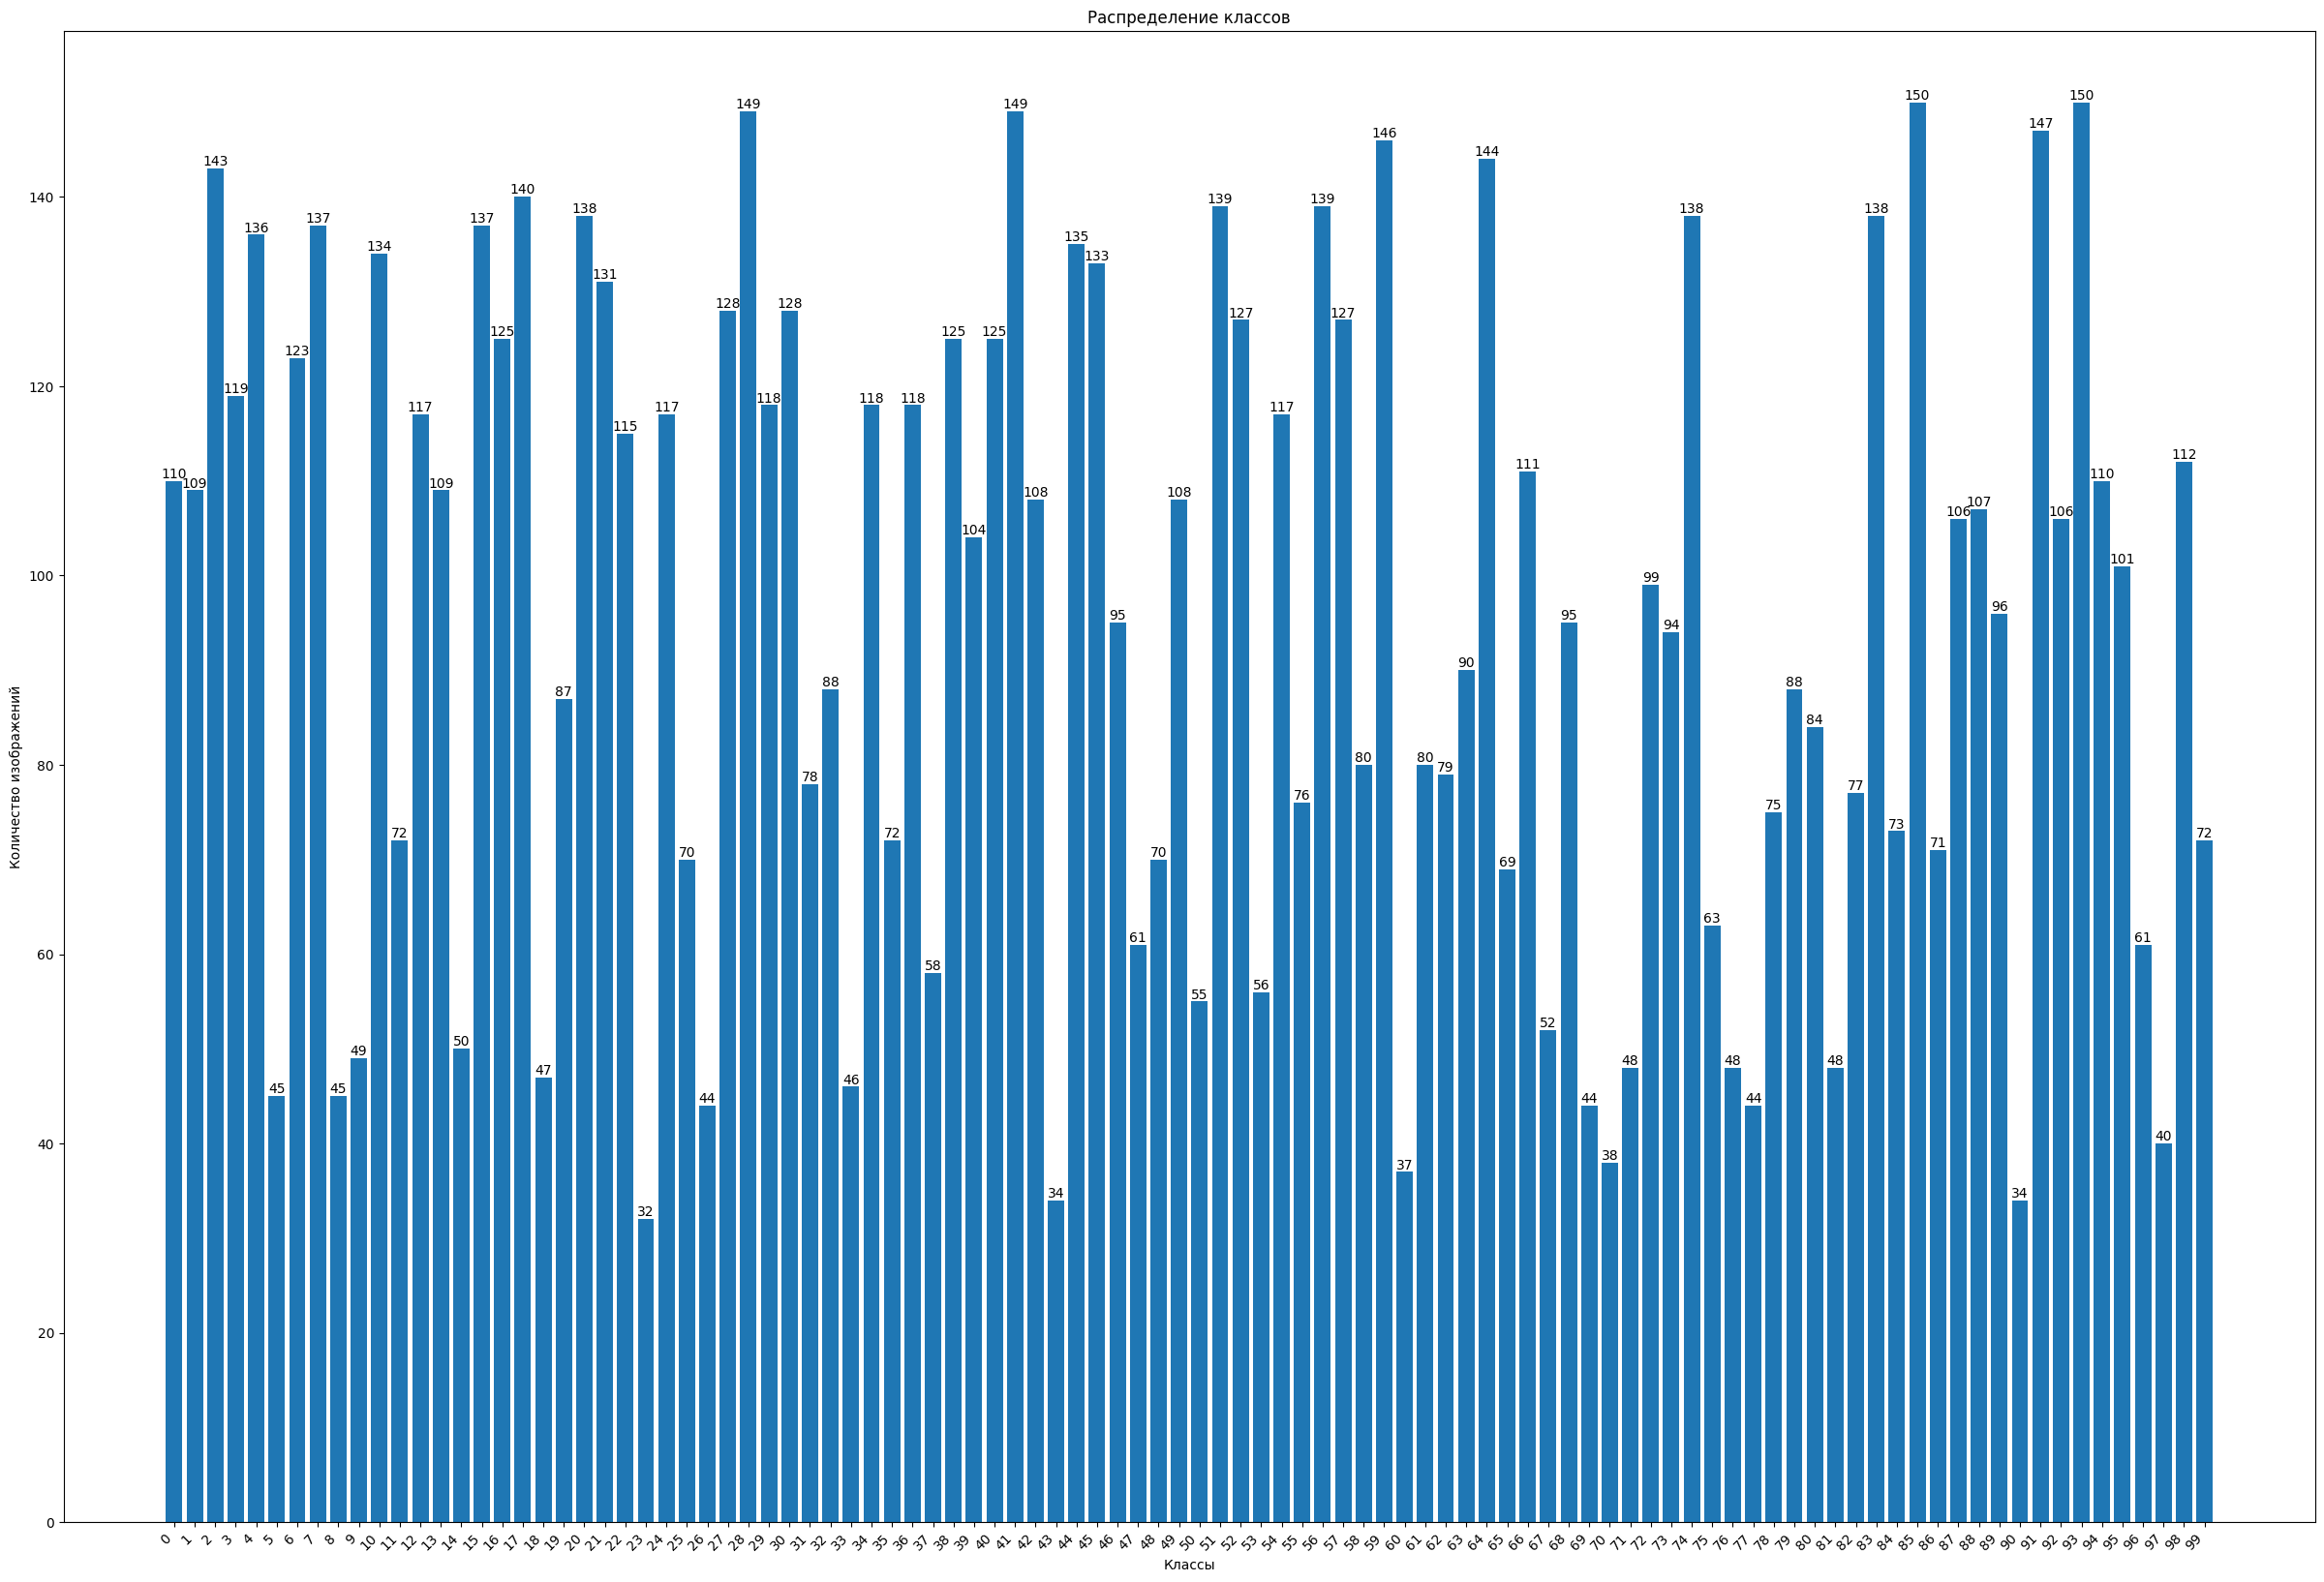

In [11]:
def check_class_balance(dataset):
    mass = np.array([])

    class_counts = Counter(dataset.targets)
    class_names = dataset.class_folders

    print("\nСтатистика по классам:")
    print(f"Всего классов: {len(class_names)}")
    print(f"Всего изображений: {len(dataset)}")
    print("\nКоличество изображений по классам:")
    for class_idx, count in class_counts.items():
        print(f"{class_names[class_idx]}: {count} ({(count/len(dataset))*100:.1f}%)")
        mass = np.append(mass,count)
    print(f'Cреднее кол-во изоражений на класс:{np.mean(mass)}')
    print(f'Классы,в которых кол-во изображений меньше среднего:{np.array(class_names)[np.where(mass<np.mean(mass))]}]')


    plt.figure(figsize=(30, 20))


    bars = plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
    plt.title('Распределение классов')
    plt.xlabel('Классы')
    plt.ylabel('Количество изображений')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')


check_class_balance(dataset)

In [12]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

class TestDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        # Сортируем файлы по числовому значению в названии
        self.image_paths = sorted(
            [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.png')],
            key=lambda x: natural_sort_key(os.path.basename(x)))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image

In [76]:
test_transform = A.Compose([
  A.Resize(224, 224, interpolation=cv2.INTER_CUBIC),


   A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

ToTensorV2()]
)

In [77]:
test_dataset = TestDataset(images_dir="/content/drive/MyDrive/kaggle/data/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [78]:
train_dataset1, val_dataset = random_split(dataset, [0.7,0.3])

In [79]:
val_dataset.dataset.transform = test_transform

In [80]:
train_loader = DataLoader(train_dataset1,batch_size = 128,shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset,batch_size = 128,shuffle=False)

Приступим к написанию собственной сети:)

In [81]:
class MyNN(nn.Module):
    def __init__(self, num_classes=100):
        super(MyNN, self).__init__()


        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.5)


        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)
        self.skip2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, stride=1),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.AdaptiveMaxPool2d(1)
        self.dropout3 = nn.Dropout(0.25)
        self.skip3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),
            nn.AdaptiveMaxPool2d(1)
        )


        self.fc1 = nn.Linear(128, 256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):

        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = self.maxpool1(x1)
        x1 = self.dropout1(x1)


        x2 = F.relu(self.bn2(self.conv2(x1)))
        x2 = self.maxpool2(x2)
        x2 = self.dropout2(x2)
        x1_skip = self.skip2(x1)
        x2 = x2 + x1_skip


        x3 = F.relu(self.bn3(self.conv3(x2)))
        x3 = self.maxpool3(x3)
        x3 = self.dropout3(x3)
        x2_skip = self.skip3(x2)
        x3 = x3 + x2_skip


        x3 = x3.view(x3.size(0), -1)
        x3 = F.relu(self.fc1(x3))
        x3 = self.dropout_fc(x3)
        x3 = F.relu(self.fc2(x3))
        x3 = self.fc3(x3)
        return x3

In [82]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [83]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=MyNN(num_classes=100).to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
num_epochs = 20
scheduler = ExponentialLR(optimizer,gamma=0.9)

In [84]:
def train_epoch(model,criterion,optimizer,scheduler, train_loader, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total+=targets.shape[0]
        running_loss += loss.item()*inputs.shape[0]
        _, predicted = outputs.max(1)
        correct += (predicted==targets).sum().item()
    scheduler.step()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    return(train_acc,train_loss)


In [85]:
def validate(model,criterion,optimizer, val_loader, device):
  model.eval()
  running_val_loss, correct, total = 0.0, 0, 0
  with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
  val_loss = running_val_loss / len(val_loader.dataset)
  val_acc = 100. * correct / total
  return(val_acc,val_loss)

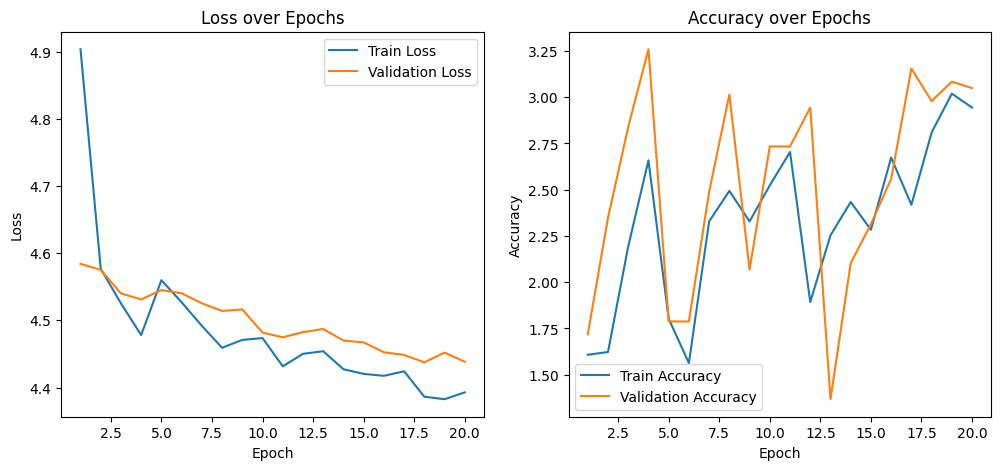

100%|██████████| 20/20 [13:23<00:00, 40.16s/it]

Epoch 20/20 | LR: 0.001216 | Train Loss: 4.3928, Train Acc: 2.94% | Val Loss: 4.4384, Val Acc: 3.05%


In [86]:
for epoch in tqdm(range(num_epochs)):
  train_acc,train_loss = train_epoch(model,criterion,optimizer,scheduler, train_loader, device)
  val_acc, val_loss =  validate(model,criterion,optimizer, val_loader, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_acc)
  val_accuracies.append(val_acc)
  clear_output(wait=True)
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
  plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss over Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
  plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy over Epochs")
  plt.legend()
  plt.show()

  print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

В общем, не сахар, попробуем efficient net

In [22]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
def get_model(
    pretrain=True,
    freeze_backbone=False,
    dropout_rate=0.5,
    num_classes=100
):

    if pretrain:
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        m = efficientnet_b0(weights=weights)
    else:
        m = efficientnet_b0(weights=None)


    if freeze_backbone:
        for param in m.parameters():
            param.requires_grad = False


    m.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(m.classifier[-1].in_features, num_classes)
    )

    for param in m.classifier.parameters():
        param.requires_grad = True

    return m.to(device)

In [31]:
model = get_model(
    pretrain=True,
    freeze_backbone=True,
    dropout_rate=0.5
)

In [25]:
model = model.to(device)

In [26]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

In [27]:
class CustomMultiClassLoss(nn.Module):
    def __init__(self):
        super(CustomMultiClassLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = self.ce(outputs, targets)
        penalty = 0.001 * torch.mean(torch.sum(outputs**2, dim=1))
        return loss + penalty

In [28]:
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
base_lr = 0.01

scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
num_epochs = 15
scheduler = ExponentialLR(optimizer, gamma=0.95)
warmup_epochs = 3
loss_switched = False
optimizer_switched = False

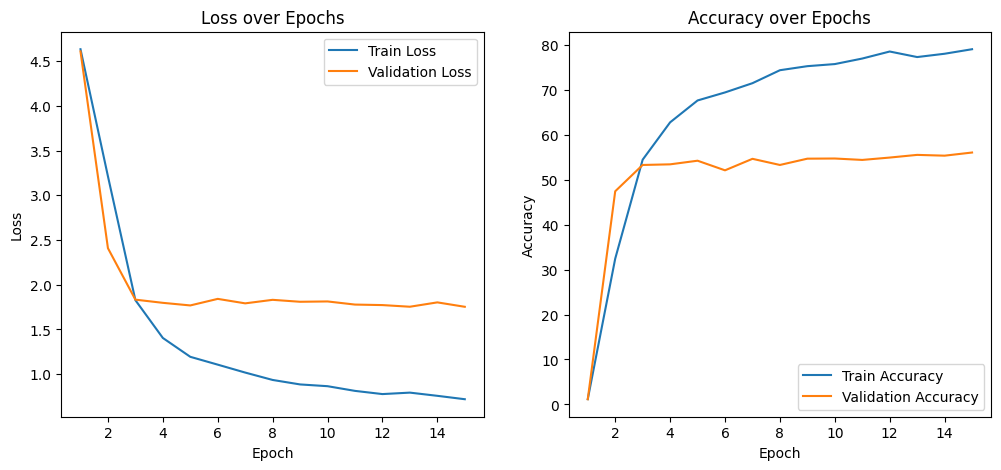

100%|██████████| 15/15 [09:43<00:00, 38.91s/it]

Epoch 15/15 | LR: 0.001884 | Train Loss: 0.7200, Train Acc: 79.03% | Val Loss: 1.7533, Val Acc: 56.05%


In [34]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

На тестовых данных модель выше дала самый высокий accuracy - 54%

In [47]:
model.eval()
predictions = []
filenames = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs,1)
        predictions.extend(predicted.cpu().numpy())


#Создаём DataFrame с id (из имени файла) и предсказаниями
results = pd.DataFrame({
    "id": [i for i in range(len(test_dataset))],  # Извлекаем число из "10.png"
    "predicted_class": predictions
}).sort_values("id")  # Сортируем по id на случай, если порядо

In [48]:
results.to_csv("test_predictions_hope_lucky_one291.csv", index=False)

Напишем генератор:)

In [37]:
new_transform = A.Compose([

   A.Normalize(),

ToTensorV2()]
)

In [39]:
new_dataset = SortedImageDataset(data,transform=new_transform)

In [40]:
train_loader_new = DataLoader(new_dataset, batch_size = 128,shuffle=True)

In [42]:
class Generator(nn.Module):
    def __init__(self, n_classes=100, latent_dim=120, img_channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes

        self.label_emb = nn.Sequential(
            nn.Embedding(n_classes, latent_dim),
            nn.Linear(latent_dim, latent_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(latent_dim * 4, latent_dim * 4),
            nn.LayerNorm(latent_dim * 4)
        )


        self.projection = nn.Sequential(
            nn.Linear(latent_dim * 5, 1024 * 4 * 4),
            nn.LayerNorm(1024 * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(

            nn.ConvTranspose2d(1024, 768, 4, 2, 1, bias=False),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.1),


            nn.ConvTranspose2d(768, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.1),


            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),


            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, img_channels, 3, 1, 1, bias=False),
            nn.Tanh()
        )


        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, noise, labels):

        embedded_labels = self.label_emb(labels)


        gen_input = torch.cat([noise, embedded_labels], dim=1)


        x = self.projection(gen_input)
        x = x.view(-1, 1024, 4, 4)


        img = self.model(x)

        return img


class Discriminator(nn.Module):
    def __init__(self, n_classes=100):
        super(Discriminator, self).__init__()

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.adv_layer = nn.Sequential(
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.aux_layer = nn.Sequential(
            nn.Conv2d(256, n_classes, 4, 1, 0, bias=False),
            nn.Softmax(dim=1)
        )

    def forward(self, img):
        out = self.conv_blocks(img)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity, label.view(label.size(0), -1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(n_classes=100).to(device)
discriminator = Discriminator(n_classes=100).to(device)


adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
epochs = 30

In [43]:
for epoch in range(epochs):
    for real_imgs, real_labels in train_loader_new:
        # Подготовка данных
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)
        valid = torch.ones(real_imgs.size(0), 1, 1, 1).to(device)
        fake = torch.zeros(real_imgs.size(0), 1,1,1).to(device)

        # Генерация фейков
        noise = torch.randn(real_imgs.size(0), 120).to(device)
        gen_labels = torch.randint(0, 100, (real_imgs.size(0),)).to(device)
        gen_imgs = generator(noise, gen_labels)


        optimizer_D.zero_grad()


        real_pred, real_aux = discriminator(real_imgs)
        fake_pred, fake_aux = discriminator(gen_imgs.detach())

        d_real_adv = adversarial_loss(real_pred, valid)
        d_fake_adv = adversarial_loss(fake_pred, fake)
        d_real_class = auxiliary_loss(real_aux, real_labels)
        d_fake_class = auxiliary_loss(fake_aux, gen_labels)

        d_loss = (d_real_adv + d_fake_adv)/2 + (d_real_class + d_fake_class)/2
        d_loss.backward()
        optimizer_D.step()


        optimizer_G.zero_grad()

        validity, pred_label = discriminator(gen_imgs)
        g_adv = adversarial_loss(validity, valid)
        g_class = auxiliary_loss(pred_label, gen_labels)

        g_loss = g_adv + g_class
        g_loss.backward()
        optimizer_G.step()

In [49]:
def generate_and_save_images(n_images_per_class=50, latent_dim=120):
    generator.eval()

    for class_id in range(100):

        labels = torch.full((n_images_per_class,), class_id, dtype=torch.long).to(device)
        noise = torch.randn(n_images_per_class, latent_dim).to(device)

        with torch.no_grad():
            gen_imgs = generator(noise, labels)

        for i in range(n_images_per_class):

            img = gen_imgs[i].cpu().numpy()
            img = np.transpose(img, (1, 2, 0))

            if img.min() < -1 or img.max() > 1:
                img = (img - img.min()) / (img.max() - img.min()) * 255
            else:
                img = (img + 1) * 127.5

            img = img.clip(0, 255).astype(np.uint8)


            Image.fromarray(img).save(f"/content/drive/MyDrive/kaggle/data/train/{class_id}/generated_{i}.png")


    print(f"Сгенерировано {n_images_per_class} изображений для каждого из 100 классов")

# Использование:
generate_and_save_images(n_images_per_class=50)

Сгенерировано 50 изображений для каждого из 100 классов


Пропишем класс Датасет, который будет содержать в себе исключительно сгенерированные изображения

In [50]:
class GeneratedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, prefix="generated"):
        self.root_dir = root_dir
        self.transform = transform
        self.prefix = prefix
        self.samples = self._find_generated_images()

    def _find_generated_images(self):
        samples = []
        for class_dir in range(100):
            class_dir = str(class_dir)
            class_path = os.path.join(self.root_dir, class_dir)
            if not os.path.isdir(class_path):
                continue
            for img_name in os.listdir(class_path):
                if img_name.startswith(self.prefix):
                    img_path = os.path.join(class_path, img_name)
                    samples.append((img_path, int(class_dir)))
        return samples

    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = np.array(Image.open(img_path).convert('RGB'))


        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label



In [51]:
data_gen =  '/content/drive/MyDrive/kaggle/data/train'
dataset_gen = GeneratedImageDataset(data_gen,transform=train_transform)

Соединим тренировочный датасет и сгенерированный(Данные на валидации - чистые, без генераций)

In [52]:
combined_train_dataset = ConcatDataset([train_dataset1, dataset_gen])

In [53]:
train_loader_gen = DataLoader(combined_train_dataset,batch_size = 128,shuffle=True, num_workers = 2)

In [55]:
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 100)
model = model.to(device)

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
base_lr = 0.01

scheduler_step = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler_exp  = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
num_epochs = 20
scheduler = ExponentialLR(optimizer, gamma=0.95)
warmup_epochs = 3
loss_switched = False
optimizer_switched = False


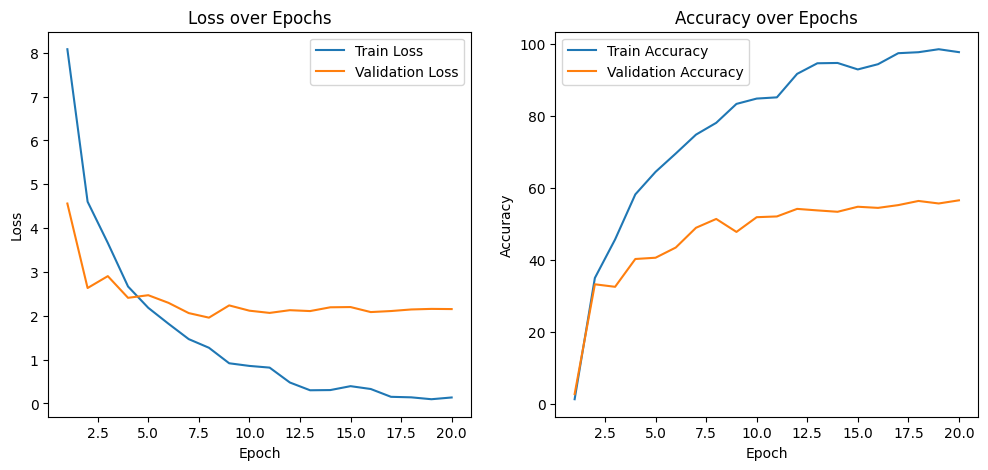

100%|██████████| 20/20 [28:25<00:00, 85.29s/it]

Epoch 20/20 | LR: 0.001112 | Train Loss: 0.1360, Train Acc: 97.83% | Val Loss: 2.1526, Val Acc: 56.57%


In [65]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader_gen:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total

    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = 100. * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Видим сильное переобучение, скорее всего такой результат из-за слабого генератора, который на каждый класс сгенерировл одинаковые изображения(mode collapse)